<a href="https://colab.research.google.com/github/FIT3164Group1/Project/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cloud_tpu_client

In [1]:
import tensorflow as tf
# from cloud_tpu_client import Client
# c = Client()
# c.configure_tpu_version(tf.__version__, restart_type="always")


try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [2]:
# Mount Project Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install split-folders tqdm
import splitfolders

# Split dataset into training, testing and validation sets
splitfolders.ratio(
    input='/content/drive/MyDrive/Realoutput/val', #
    output='/content/drive/MyDrive/output_med',
    seed=1337,
    ratio=(0.8,0.1,0.1),
    group_prefix=None
)


Copying files: 19573 files [1:13:54,  4.41 files/s]


In [3]:
 from tensorflow import keras
 import tensorflow as tf

In [ ]:
# Import training data
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/output/train',
    labels='inferred',
    label_mode='int', #sparse_categorical_crossentropy
    class_names=['MSI', 'MSS'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False
)

# Import validation data 
validate_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/output/val',
    labels='inferred',
    label_mode='int', #sparse_categorical_crossentropy
    class_names=['MSI', 'MSS'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False
)

# Import testing data
test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/output/test',
    labels='inferred',
    label_mode='int', #sparse_categorical_crossentropy
    class_names=['MSI', 'MSS'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False
)

Found 1849 files belonging to 2 classes.
Found 231 files belonging to 2 classes.
Found 233 files belonging to 2 classes.


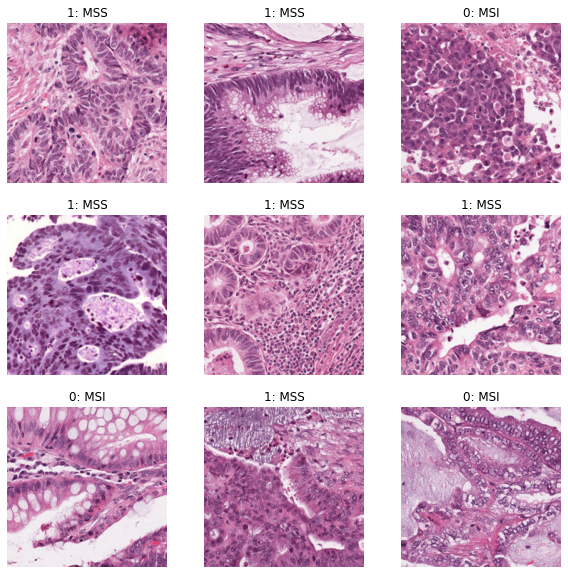

In [ ]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names

# Plot subset of images in training data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(str(labels[i].numpy())+ ': '+ class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Print shape of training data
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
import cv2
import numpy as np
from PIL import Image
def myFunc(image):
    image = np.array(image)
    hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    return Image.fromarray(hsv_image)

In [21]:
from keras.preprocessing.image import ImageDataGenerator

# Generate batches of augmented data in real-time
train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=5,
  brightness_range=[1,0.8],
  zoom_range=0.3,
  # width_shift_range=0.1,
  # height_shift_range=0.1,
  horizontal_flip=True,
  vertical_flip=True,
  # fill_mode="nearest"
  # shear_range=0.05,
  )

test_datagen = ImageDataGenerator(rescale=1./255) #Only re-scale test data (i.e. no augmentations)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/output_med/train',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary',
        shuffle=True)

validate_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/output_med/val',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary',
        shuffle=True)

test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/output_med/test',
        target_size=(224, 224),
        batch_size=16,
        class_mode='binary',
        shuffle=True)

Found 15657 images belonging to 2 classes.
Found 1957 images belonging to 2 classes.
Found 1959 images belonging to 2 classes.


In [ ]:
def preprocess_and_decode(img_str):
    decoded = tf.io.decode_base64(img_str)
    image = tf.image.decode_jpeg(decoded, channels=3)
    resized = tf.image.resize(image, size=(224, 224))
    return resized / 255

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Input
import tensorflow as tf

InputLayer = Input(shape = (1,), dtype="string", name="base64_image")
input = Lambda(lambda img : tf.map_fn(lambda im : preprocess_and_decode(im[0]), img, dtype="float32"))(InputLayer)

vgg_model = VGG16(
    include_top=False, 
    input_tensor = input
    )

for layer in vgg_model.layers:
    layer.trainable=False

flat1 = Flatten()(vgg_model.layers[-1].output)
flat1.shape
class1 = Dense(256, activation='relu')(flat1)
output = Dense(1, activation='sigmoid')(class1)

model = Model(inputs = vgg_model.inputs, outputs = output,)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b0.tar.gz
!wget https://github.com/tensorflow/tensorflow/raw/master/tensorflow/python/keras/applications/efficientnet_weight_update_util.py
!tar -xf noisy_student_efficientnet-b0.tar.gz

In [ ]:
!python efficientnet_weight_update_util.py --model b0 --notop --ckpt \
        noisy_student_efficientnet-b0/model.ckpt --o noisy_student_efficientnetb0_notop.h5

In [26]:
from tensorflow.keras.applications import EfficientNetB0, VGG16, InceptionResNetV2, Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [1]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

def preprocess_and_decode(img_str):
    decoded = tf.io.decode_base64(img_str)
    image = tf.image.decode_jpeg(decoded, channels=3)
    resized = tf.image.resize(image, size=(224, 224))
    return resized / 255

def build_model():
  # StringInputLayer = Input(shape = (1,), dtype="string", name="base64_image")
  # ArrayInputLayer = Lambda(lambda img : tf.map_fn(lambda im : preprocess_and_decode(im[0]), img, dtype="float32"))(StringInputLayer)
  
  # Create input layer to convert base64 encoded string to scaled numpy array   
  ArrayInputLayer = Input(shape = (224,224,3)) 
  # model = EfficientNetB0(include_top=False, input_tensor=ArrayInputLayer, weights="noisy_student_efficientnetb0_notop.h5")
  # model = VGG16(include_top=False, input_tensor=ArrayInputLayer)
  model = Xception(include_top=False, input_tensor=ArrayInputLayer, weights="imagenet")

  # Freeze the pretrained weights
  model.trainable = False

  # Rebuild top
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  # x = layers.Dropout(0.25, name="top_dropout_1")(x)
  x = Flatten()(x)
  x = Dense(256, name='fully_connected')(x)
  x = layers.Activation('relu')(x)
  x = layers.Dropout(0.5, name="top_dropout_2")(x)
  # x = layers.Dropout(0.4, name="top_dropout_2")(x)
  output = layers.Dense(1, activation="sigmoid", name="pred")(x)

  # Compile
  model = tf.keras.Model(ArrayInputLayer, output, name="VGG16")
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
  model.compile(
      optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
  )
  return model

In [38]:
model = build_model()
model.summary()

Model: "VGG16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path('/content/drive/MyDrive/output/train/MSS').rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [34]:
def unfreeze_model(model):
    # We unfreeze the top block layers while leaving BatchNorm layers frozen
    for layer in model.layers[-21:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
            print(layer)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )

In [ ]:
with strategy.scope():
    model = build_model()
    unfreeze_model(model)

epochs = 20
hist = model.fit(train_generator, epochs=epochs, validation_data=validate_generator, verbose=1)
plot_hist(hist)

Epoch 1/20
979/979 [==============================] - 360s 362ms/step - loss: 0.6305 - accuracy: 0.6468 - val_loss: 0.5740 - val_accuracy: 0.7026
Epoch 2/20
979/979 [==============================] - 336s 343ms/step - loss: 0.5729 - accuracy: 0.7022 - val_loss: 0.5288 - val_accuracy: 0.7496
Epoch 3/20
979/979 [==============================] - 342s 350ms/step - loss: 0.5378 - accuracy: 0.7279 - val_loss: 0.4982 - val_accuracy: 0.7649
Epoch 4/20
979/979 [==============================] - 330s 337ms/step - loss: 0.5089 - accuracy: 0.7517 - val_loss: 0.4917 - val_accuracy: 0.7532
Epoch 5/20
979/979 [==============================] - 335s 342ms/step - loss: 0.4867 - accuracy: 0.7656 - val_loss: 0.4758 - val_accuracy: 0.7614
Epoch 6/20
979/979 [==============================] - 333s 340ms/step - loss: 0.4607 - accuracy: 0.7811 - val_loss: 0.4623 - val_accuracy: 0.7818
Epoch 7/20
979/979 [==============================] - 351s 358ms/step - loss: 0.4385 - accuracy: 0.7920 - val_loss: 0.4489 -

In [25]:
model.save(
    filepath="/content/drive/MyDrive/SavedModels/VGG/VGG_778",
    save_format="tf"
    )
# tf_model = tf.saved_model.load('/content/drive/MyDrive/SavedModels/VGG/VGG_MSI_MSS_prediction')
# tf_model.signatures

INFO:tensorflow:Assets written to: /content/drive/MyDrive/SavedModels/VGG/VGG_778/assets


In [72]:
import base64
import numpy as np
base64_bytes = 0

with open('output_med/val/MSS/blk-CGPIRCEWSLPV-TCGA-DC-6683-01Z-00-DX1.jpg', "rb") as imageFile:
    base64_bytes = base64.urlsafe_b64encode(imageFile.read())

print(base64_bytes.decode())
# TODO: remove ' ' chars and 'b' prefix from b64 string for REST API
# prediction = model.predict([base64_bytes,])


_9j_4AAQSkZJRgABAQEASABIAAD_2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT_2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT_wAARCADgAOADAREAAhEBAxEB_8QAHQAAAgMBAQEBAQAAAAAAAAAABQYDBAcIAgEACf_EAD0QAAEDAwMDAwMCBQMDAwQDAAECAwQFBhEAEiEHEzEiQVEUMmEVcQgjQoGRFlKhJLHBFzNiJTRD4XKS8P_EABoBAAMBAQEBAAAAAAAAAAAAAAIDBAEFAAb_xAAzEQACAgEDAwIEBQQDAQEBAAABAgADERIhMQQTQSJRMmFxgQUjkaHwFLHB4TNC0fFSRP_aAAwDAQACEQMRAD8A_oLdvUy27JSn9TqKe73246o8cd11srOApaRylI8knwNUpS7_AAidCrpbrhlV29_Ezm5v4ienlx0OrUV-uphxZ6FwBNVkt7lJwNxT9oOcf31QnTXKwbGcbzor-H206bTg-Zy0izKn0etmrVltv_VEaozWhGap53sobBKd6R88eB5411ywsbSpwfnPoqrBnjI9vaGLdiVSYy_csqK7EqE9pMaJGmtHMUDlKjjnHwD_AM6wlR6PaMYayWXzFOzqjX6PJqNq1gLpoqDShGkNNIdIcUpX_VqVjJGcEAfHtjSrba1sUck_2l1HQX29NZevpCjmM1my4vQ-2JtXams3NVqliE69zmWpHuneRlYBJOPOmOneIUbATi9vWQX3MZrhvOL0-bi1Uw9yLiaD62I7XbKm1IypJKzhJH_OQR5zpYQ2DH_5lVdK2EqB5gnp70og2vTKrNTXmFQLnjkR2h_LejoWpROQn7OcAk-CNE9wbAA4k61uljKQdvYYgqR0ArsPp5U6

In [46]:
np.set_printoptions(threshold=np.inf)
from PIL import Image
import json
image = Image.open('images/msi1.png')
image_array = np.array(image)
# np.savetxt('images/sample.txt', np.array2string(image_array))
print()

f = open('images/sample.txt', 'w')
# f.write(np.array2string(image_array/255.0, max_line_width=9999999999999999, separator=''))
f.write(json.dumps(image_array.tolist()))

839249

In [58]:
import tensorflow as tf
from tensorflow import keras
keras.models.load_model('Models/Xception/1')

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
model.summary()
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_generator,
                    validation_data = validate_generator,
                    epochs=2, verbose=1, steps_per_epoch=5)

In [ ]:
model.save(
    filepath="/content/drive/MyDrive/SavedModels/VGG/VGG_b64_1",
    save_format="tf"
    )

INFO:tensorflow:Assets written to: /content/drive/MyDrive/SavedModels/VGG/VGG_b64_1/assets


In [ ]:
model.evaluate(
    x=test_generator,
    steps=2
)

2/2 [==============================] - 18s 9s/step - loss: 1.1301 - accuracy: 0.5312


[1.13010573387146, 0.53125]

In [ ]:
import sys
if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''

In [ ]:
!curl https://sdk.cloud.google.com | bash

In [ ]:
!gcloud init

In [ ]:
PROJECT_ID = "fit3164-group-1"
BUCKET_NAME= "vgg-model"
BUCKET_LOCATION='AUSTRALIA-SOUTHEAST2'

!gsutil mb -p $PROJECT_ID -l $BUCKET_LOCATION -b on gs://$BUCKET_NAME

Creating gs://vgg-model/...


In [ ]:
DESTINATION_BUCKET_NAME = "vgg-model"
OBJECT_LOCATION = "/content/drive/MyDrive/SavedModels/VGG/VGG_MSI_MSS_prediction"

!gsutil cp -r $OBJECT_LOCATION gs://$DESTINATION_BUCKET_NAME/

In [ ]:
MODEL_NAME="vgg_prediction_model"
REGION='australia-southeast1'

!gcloud ai-platform models create $MODEL_NAME \
  --region=$REGION

Using endpoint [https://australia-southeast1-ml.googleapis.com/]
Created ai platform model [projects/fit3164-group-1/models/vgg_prediction_model].


In [ ]:
FRAMEWORK="TENSORFLOW"
REGION='australia-southeast1'
MODEL_NAME="vgg_prediction_model"
MODEL_DIR="gs://vgg-model/VGG_MSI_MSS_prediction"
VERSION_NAME="v1_0"

!gcloud ai-platform versions create $VERSION_NAME \
  --model=$MODEL_NAME \
  --origin=$MODEL_DIR \
  --runtime-version=2.5 \
  --framework=$FRAMEWORK \
  --python-version=3.7 \
  --region=$REGION

Using endpoint [https://australia-southeast1-ml.googleapis.com/]


In [ ]:
# JSON prediction

# Import the base64 encoding library.
import tensorflow as tf
from tensorflow import keras

jpeg_data = open(
    file='/content/drive/MyDrive/Dataset/MSI/blk-AAADECQEWVSD-TCGA-CM-4746-01Z-00-DX1.jpg',
    mode='rb',
    encoding=None
).read()

# jpeg_data = tf.keras.utils.load_img(
#     '/content/drive/MyDrive/Dataset/MSI/blk-AAADECQEWVSD-TCGA-CM-4746-01Z-00-DX1.jpg'
# )

# jpeg_data = tf.keras.utils.img_to_array(jpeg_data)/255



In [ ]:
import json

with open('/content/drive/MyDrive/Dataset/MSI/blk-AAADECQEWVSD-TCGA-CM-4746-01Z-00-DX1.jpg', "rb") as imageFile:
    base64_bytes = base64.urlsafe_b64encode(imageFile.read())

data = {
    "instances": [
      [str(base64_bytes.decode())]
  ]
}

with open('/content/drive/MyDrive/request.json', 'w') as outfile:
    json.dump(data, outfile)

In [ ]:
# Make prediction
MODEL_NAME="vgg_prediction_model"
MODEL_VERSION="v1_0"


!gcloud ai-platform predict \
--model $MODEL_NAME \
--version $MODEL_VERSION \
--json-request '/content/drive/MyDrive/request.json'

In [ ]:
DATA_FORMAT="text" # JSON data format
INPUT_PATHS='gs://vgg-model/request.json'
OUTPUT_PATH='gs://vgg-model/'
MODEL_NAME="vgg_prediction_model"
VERSION_NAME="vgg_prediction_model"
REGION='australia-southeast1'
MODEL_DIR="gs://vgg-model/VGG_MSI_MSS_prediction"
JOB_NAME="job1"
RUNTIME_VERSION="2.1"

!gcloud ai-platform jobs submit prediction $JOB_NAME \
    --model-dir $MODEL_DIR \
    --input-paths $INPUT_PATHS \
    --output-path $OUTPUT_PATH \
    --region $REGION \
    --data-format $DATA_FORMAT \
    --runtime-version $RUNTIME_VERSION

In [ ]:
!gcloud ai-platform jobs describe job1